# Candidate Test 2022 Analysis Part 1

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2).

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:
- Age of the candidates grouped by parties.
- An overview of the most "confident" candidates, i.e., those with the highest proportion of "strongly agree" or "strongly disagree" responses.
- Differences in responses between candidates, both inter-party and intra-party, along with an explanation of which parties have the most internal disagreements.
- Classification models to predict candidates' party affiliations. Investigate if there are any candidates who seem to be in the "wrong" party based on their political landscape positions. You must use the following three algorithms: **Decision Tree, Random Forrest, and Gradient Boosted Tree**, and **two other** classification algorithms of your choice.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



In [156]:
import pandas as pd
import matplotlib.pyplot as plt
from utils import generate_random_colors

# load data
df = pd.read_excel('alldata.xlsx')

print(df.index)


RangeIndex(start=0, stop=867, step=1)


In [157]:

# group data by party
grouped_by_party = df.groupby(['parti'])

# display average age
display(grouped_by_party['alder'].mean().round(1))


parti
Alternativet                                   46.0
Danmarksdemokraterne                           51.2
Dansk Folkeparti                               45.5
Det Konservative Folkeparti                    42.9
Enhedslisten                                   40.5
Frie Grønne, Danmarks Nye Venstrefløjsparti    34.8
Kristendemokraterne                            49.0
Liberal Alliance                               36.9
Løsgænger                                      48.0
Moderaterne                                    44.3
Nye Borgerlige                                 47.6
Radikale Venstre                               45.0
Socialdemokratiet                              44.3
Socialistisk Folkeparti                        40.9
Venstre                                        46.7
Name: alder, dtype: float64

In [158]:
# create a data frame where for each element value is true if the coressponding value was 2 or -2, otherwise false
count = (df == 2) | (df == -2)

# create a confidance column with sum of true values from count dataframe
df['confidence'] = count.sum(axis=1)

# select name and confidence from df and sort the values based on confidence in descending order
df[['navn', 'confidence']].sort_values(by='confidence', ascending=False)

,navn,confidence
505,Sarah Nørris,49
88,Søren Vanting,49
559,Kim Andkjær Doberck,44
152,Rashid Ali,43
44,Mohamed Abdikarim,43
...,...,...
226,Halima El Abassi,2
509,Michael Mikkelsen,0
643,Søren Lund Hansen,0
699,Kasper Roug,0


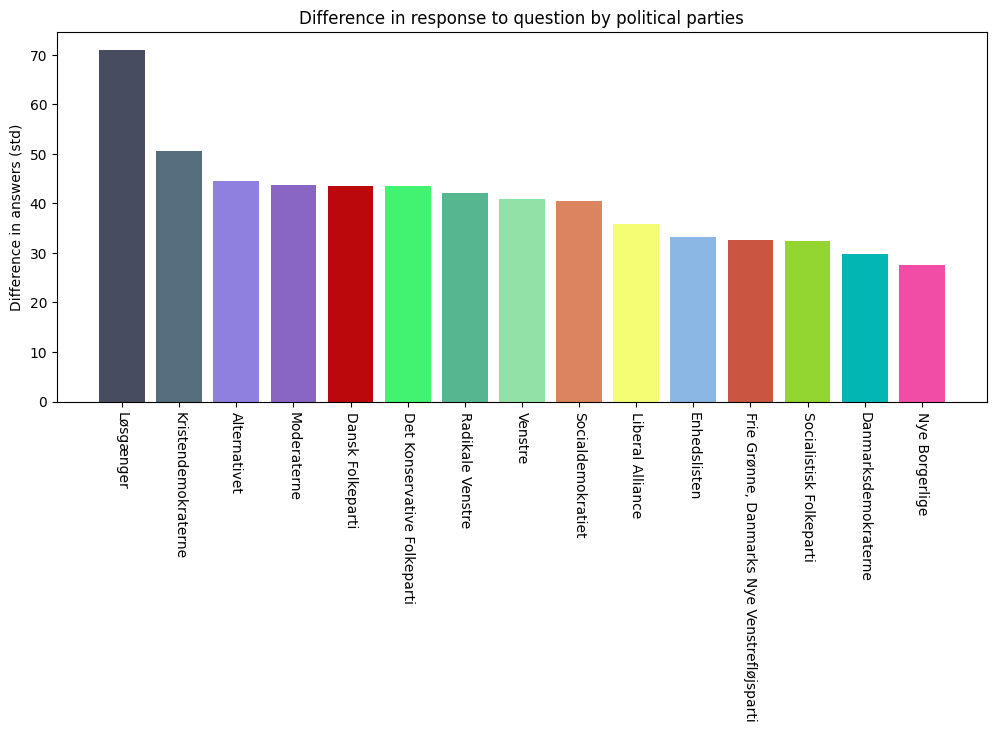

In [159]:

drop_cols = ['storkreds', 'navn', 'alder', 'confidence']
questions_df = df.drop(columns=drop_cols)

# group data by party
grouped_by_party = questions_df.groupby(['parti'])

# calculate standard deviation for each question group by party
std_by_question = grouped_by_party.std()

# sum question together, sort in descending order
std_by_party = std_by_question.sum(axis=1).sort_values(ascending=False)

# get keys and values of standard deviation summed up
parties = std_by_party.keys()
values = std_by_party.values

# plotting data
fig, ax = plt.subplots()

fig.set_figwidth(12)

colors = generate_random_colors(len(parties))

ax.set_ylabel('Difference in answers (std)')
ax.set_title('Difference in response to question by political parties')
ax.bar(parties, values, color=colors)
ax.tick_params(axis='x', labelrotation=270)

plt.show()



According to my analysis, Losgaenger is the party that has the most disagreements. Nye Borgerlige on the other hand, is that party that has the least disagreements.

### Difference between candidates
While difference within a party can by calculated using standard deviation, it can't really be used to calculate differences between two specific candiates. To do that we can calculate how many steps are needed to go from one candidates answers to second.

In [160]:
drop_cols = ['storkreds', 'alder', 'parti', 'confidence']
answers_df = df.drop(columns=drop_cols)


#helper function to calculate difference between two candidates
def get_candidates_difference(candidate1, candidate2): 
    difference_count = 0
    for (columnName, columnData) in answers_df.items():
        if( columnName != 'navn' ):
            difference_count += abs(candidate1[1][columnName] - candidate2[1][columnName])

    return difference_count, candidate1, candidate2


# let's calculate biggest difference between two candidates, regardless of party
max_diff = 0
c1_temp = None
c2_temp = None

for candidate1 in answers_df.iterrows():
    for candidate2 in answers_df.iterrows():
        diff, c1, c2 = get_candidates_difference(candidate1, candidate2)

        if(diff > max_diff): 
            max_diff = diff
            c1_temp = c1
            c2_temp = c2

print(f"The maximum difference is: {max_diff}. It is between candidate {c1_temp[1]['navn']} and {c2_temp[1]['navn']}")

The maximum difference is: 168. It is between candidate Sarah Nørris and Rikke Norlyk


Let's do the same within a party, to do that we need to create an average candidate for each party

In [164]:
drop_cols = ['storkreds', 'alder', 'confidence']
answers_df = df.drop(columns=drop_cols, axis=1)

def get_candidates_difference(candidate1, candidate2): 
    difference_count = 0
    for (columnName, columnData) in answers_df.items():
        if( columnName not in ['navn', 'parti'] ):
            difference_count += abs(candidate1[1][columnName] - candidate2[1][columnName])

    return difference_count, candidate1, candidate2

# group data by party
grouped_by_party = answers_df.groupby('parti')

# loop through parties
for by_party_label, by_party_data in grouped_by_party:

    # create an average candidate
    avg_party_candidate = by_party_data.loc[:, ~by_party_data.columns.isin(['navn', 'parti'])].mean()
    # create a tuple from avg candidate
    avg_party_candidate = ('Average', avg_party_candidate)

    # fig, ax = plt.subplots()
    # fig.set_figwidth(15)
    # ax.set_ylabel(f'Difference in answers')
    # ax.set_title(by_party_data['parti'].values[0])
    # ax.tick_params(axis='x', labelrotation=270)

    plot_labels = []
    plot_height = []
    # iterate through party candidates
    for candidate_data in by_party_data.iterrows():

        # get difference between a candidate and party average
        diff, c1, c2 = get_candidates_difference(candidate_data, avg_party_candidate)

        # plot_labels.append(candidate_data[1]['navn'])
        # plot_height.append(diff)

    # ax.bar(plot_labels, plot_height, color=colors)



# for party in grouped_by_party:

#     avg_candidate = party

### Models

In [237]:
from sklearn.model_selection import train_test_split
import numpy as np


drop_cols = ['storkreds', 'navn', 'alder', 'confidence', 'parti']
questions_df = df.drop(columns=drop_cols)

target = df['parti']
data = questions_df

def plot_feature_importances(model):
    n_features = data.shape[1]
    plt.figure(figsize=(20,30))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), data.columns.values, fontsize=8)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

X_rest, X_test, y_rest, y_test = train_test_split(data, target, stratify=target, random_state=41)
X_train, X_val, y_train, y_val = train_test_split(X_rest, y_rest, stratify=y_rest, random_state=41)

### Decision Tree

In [248]:
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'depth': [5, 10, 50, 100],
    'samples_split': [2, 4, 8, 12, 20]
}

best_params = {}
best_score = 0

for d in param_grid['depth']:
    for s in param_grid['samples_split']:
        tree = DecisionTreeClassifier(max_depth=d, min_samples_split=s, random_state=0)
        tree.fit(X_train, y_train)

        if tree.score(X_val, y_val) > best_score:
            best_score = tree.score(X_val, y_val)
            print(f'New best accuracy: {best_score}')
            best_params = {'depth': d, 'samples_split': s}


print(best_params)

tree = DecisionTreeClassifier(max_depth=best_params['depth'], min_samples_split=best_params['samples_split'], random_state=0)
tree.fit(X_rest, y_rest)

tree.score(X_test, y_test)
# plot_feature_importances(tree)

New best accuracy: 0.6257668711656442
New best accuracy: 0.6625766871165644
New best accuracy: 0.6871165644171779
New best accuracy: 0.6932515337423313
New best accuracy: 0.6993865030674846
{'depth': 10, 'samples_split': 12}


0.7050691244239631

### Random forest

In [256]:
from sklearn.ensemble import RandomForestClassifier

param_grid= {
    'n': [25, 50, 100, 150],
    'depth': [5,7,10,15],
    'max_f': [7,10,20,30,40]
}

best_params = {}
best_score = 0

for n in param_grid['n']:
    for d in param_grid['depth']:
        for mf in param_grid['max_f']:

            forest = RandomForestClassifier(n_estimators = n, max_depth = d, max_features = mf, random_state = 42)
            forest.fit(X_train, y_train)

            if forest.score(X_val, y_val) > best_score:
                best_score = forest.score(X_val, y_val)
                print(f'New best accuracy: {best_score}')
                best_params = {'depth': d, 'n': n, 'max_f': mf}

print(best_params)

forest = RandomForestClassifier(n_estimators = best_params['n'], max_depth  = best_params['depth'], max_features  = best_params['max_f'], random_state = 42)
forest.fit(X_rest, y_rest)

forest.score(X_test, y_test)
# plot_feature_importances(forest)

New best accuracy: 0.8711656441717791
New best accuracy: 0.8895705521472392
New best accuracy: 0.8957055214723927
New best accuracy: 0.9141104294478528
New best accuracy: 0.9202453987730062
{'depth': 7, 'n': 100, 'max_f': 7}


0.9124423963133641

### Gradient Boosted Tree

In [222]:
from sklearn.ensemble import GradientBoostingClassifier

boosted = GradientBoostingClassifier(random_state = 42, n_estimators = 100, max_depth = 3, learning_rate = 0.01)
boosted.fit(X_train, y_train)

print("Train accuracy: {}".format(boosted.score(X_train, y_train)))
print("Test accuracy: {}".format(boosted.score(X_test, y_test)))
# plot_feature_importances(boosted)

Train accuracy: 0.9646153846153847
Test accuracy: 0.8294930875576036


# Logistic Regression 
Note: Feature scaling doesn't improve model performance for tree based models, for logistic regression on the other hand, it might improve it's performance

In [ ]:
from sklearn.preprocessing import StandardScaler

# Logical regression model converges faster if the data is scaled
# Standard scaler is used to scale the data
scaler = StandardScaler()

# Scaler is fit only on training data, because we want to avoid data leakage
X_train = scaler.fit_transform(X_train)

# Test data is transformed
X_test = scaler.transform(X_test)

In [227]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2', C=0.1, max_iter=1000)
lr.fit(X_train, y_train)

print("Train accuracy: {}".format(lr.score(X_train, y_train)))
print("Test accuracy: {}".format(lr.score(X_test, y_test)))

from sklearn.neighbors import KNeighborsClassifier

Train accuracy: 0.9815384615384616
Test accuracy: 0.8940092165898618


### KNN Classifier

In [231]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=10, metric='euclidean')
knn.fit(X_train, y_train)

print("Train accuracy: {}".format(knn.score(X_train, y_train)))
print("Test accuracy: {}".format(knn.score(X_test, y_test)))

from sklearn.neighbors import KNeighborsClassifier

Train accuracy: 0.9138461538461539
Test accuracy: 0.880184331797235
